## Things to try:
* Look at other notebooks for data preprocessing
* Look at other notebooks for data visualization
* Bet against odds ... %

## Scrape Betting data and simulate if bet according to startegy will win money

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# loading CSV files downloaded from Kaggle
path = "data/"
df = pd.read_csv(path + "spreadspoke_scores.csv")
teams = pd.read_csv(path + "nfl_teams.csv")
teams_clean = pd.read_csv(path + "nfl_teams_clean.csv")
games_elo = pd.read_csv(path + "nfl_elo.csv")

In [3]:
df.shape

(12404, 17)

In [4]:
df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,09/02/1966,1966,1,False,Miami Dolphins,14.0,23.0,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71,NaN
1,09/03/1966,1966,1,False,Houston Oilers,45.0,7.0,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70,NaN
2,09/04/1966,1966,1,False,San Diego Chargers,27.0,7.0,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82,NaN
3,09/09/1966,1966,2,False,Miami Dolphins,14.0,19.0,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78,NaN
4,09/10/1966,1966,1,False,Green Bay Packers,24.0,3.0,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62,NaN


In [5]:
teams.head()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Phoenix Cardinals,Cardinals,ARI,CRD,NFC,NaN,NFC,NFC East
2,St. Louis Cardinals,Cardinals,ARI,ARI,NFC,NaN,NFC,NFC East
3,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central


In [6]:
games_elo.tail()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,score1,score2
4782,12/30/18,2018,0,NaN,SEA,ARI,1602.533070,1326.059193,0.877147,0.122853,1605.481630,1323.110633,27,24
4783,12/30/18,2018,0,NaN,DEN,LAC,1439.886121,1604.977617,0.359814,0.640186,1421.246292,1623.617446,9,23
4784,12/30/18,2018,0,NaN,WSH,PHI,1430.542116,1602.775278,0.350399,0.649601,1409.032688,1624.284707,0,24
4785,12/30/18,2018,0,NaN,KC,OAK,1649.009776,1362.709331,0.883113,0.116887,1656.058181,1355.660927,35,3
4786,12/30/18,2018,0,NaN,TEN,IND,1562.545982,1541.055633,0.621961,0.378039,1525.860805,1577.740810,17,33


# Loading and Cleaning Data

In [7]:
# replacing blank strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# removing rows from specific columns that have null values, resetting index and changing data types
df = df[(df.score_home.isnull() == False) & (df.team_favorite_id.isnull() == False) & (df.over_under_line.isnull() == False) &
        (df.schedule_season >= 1979)]

df.reset_index(drop=True, inplace=True)
df['over_under_line'] = df.over_under_line.astype(float)

# mapping team_id to the correct teams
df['team_home'] = df.team_home.map(teams.set_index('team_name')['team_id'].to_dict())
df['team_away'] = df.team_away.map(teams.set_index('team_name')['team_id'].to_dict())

# fix team_favorite_id for Colts in 1969 and 1971 SB
df.loc[(df.schedule_season == 1968) & (df.schedule_week == 'Superbowl'), 'team_favorite_id'] = 'IND'
df.loc[(df.schedule_season == 1970) & (df.schedule_week == 'Superbowl'), 'team_favorite_id'] = 'IND'

# creating home favorite and away favorite columns (fill na with 0's)
df.loc[df.team_favorite_id == df.team_home, 'home_favorite'] = 1
df.loc[df.team_favorite_id == df.team_away, 'away_favorite'] = 1
df.home_favorite.fillna(0, inplace=True)
df.away_favorite.fillna(0, inplace=True)

# creating over / under column (fill na with 0's)
df.loc[((df.score_home + df.score_away) > df.over_under_line), 'over'] = 1
df.over.fillna(0, inplace=True)

# stadium neutral and schedule playoff as boolean
df['stadium_neutral'] = df.stadium_neutral.astype(int)
df['schedule_playoff'] = df.schedule_playoff.astype(int)

# change data type of date columns
df['schedule_date'] = pd.to_datetime(df['schedule_date'])
games_elo['date'] = pd.to_datetime(games_elo['date'])

In [8]:
# fixing some schedule_week column errors and converting column to integer data type
df.loc[(df.schedule_week == '18'), 'schedule_week'] = '17'
df.loc[(df.schedule_week == 'Wildcard') | (df.schedule_week == 'WildCard'), 'schedule_week'] = '18'
df.loc[(df.schedule_week == 'Division'), 'schedule_week'] = '19'
df.loc[(df.schedule_week == 'Conference'), 'schedule_week'] = '20'
df.loc[(df.schedule_week == 'Superbowl') | (df.schedule_week == 'SuperBowl'), 'schedule_week'] = '21'
df['schedule_week'] = df.schedule_week.astype(int)

In [9]:
# Cleaning games_elo and df to merge correctly
wsh_map = {'WSH' : 'WAS'}
games_elo.loc[games_elo.team1 == 'WSH', 'team1'] = 'WAS' 
games_elo.loc[games_elo.team2 == 'WSH', 'team2'] = 'WAS'

# fix dates
df.loc[(df.schedule_date == '2016-09-19') & (df.team_home == 'MIN'), 'schedule_date'] = datetime.datetime(2016, 9, 18)
df.loc[(df.schedule_date == '2017-01-22') & (df.schedule_week == 21), 'schedule_date'] = datetime.datetime(2017, 2, 5)
df.loc[(df.schedule_date == '1990-01-27') & (df.schedule_week == 21), 'schedule_date'] = datetime.datetime(1990, 1, 28)
df.loc[(df.schedule_date == '1990-01-13'), 'schedule_date'] = datetime.datetime(1990, 1, 14)
games_elo.loc[(games_elo.date == '2016-01-09'), 'date'] = datetime.datetime(2016, 1, 10)
games_elo.loc[(games_elo.date == '2016-01-08'), 'date'] = datetime.datetime(2016, 1, 9)
games_elo.loc[(games_elo.date == '2016-01-16'), 'date'] = datetime.datetime(2016, 1, 17)
games_elo.loc[(games_elo.date == '2016-01-15'), 'date'] = datetime.datetime(2016, 1, 16)

In [10]:
# Drop season before 2000
df = df.drop(df[df.schedule_season < 2000].index)

# Create new features 
- Current W-L %
- Last season W-L % (need to manually insert for 2001 season or include 2000 season and discard)

**Need current W-L for home and away!**

In [11]:
for team in teams.team_id.unique().tolist():
    for season in range(2000,2019): 
        
        wins, games_played = 0., 0.
        
        for week in range(1,18):
            current_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == week)]

            # If a game exists
            if(current_game.shape[0] == 1):
                current_game = current_game.iloc[0]
                
    
                if ((current_game.team_home == team) & (current_game.score_home > current_game.score_away)):
                    wins += 1
                    
                elif ((current_game.team_away == team) & (current_game.score_away > current_game.score_home)):
                    wins += 1
                
                # If not a tie count game as part of record
                if(current_game.score_away != current_game.score_home):
                    games_played += 1
                
                
                if(current_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == week), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                else:
                    df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == week), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                    
        # if beyond week 17 (playoffs use season record)
        for postseason_week in range(18,22):
            current_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == postseason_week)]
            # If a game exists
            if(current_game.shape[0] == 1):
                current_game = current_game.iloc[0]
                if(current_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == postseason_week), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                else:
                    df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == postseason_week), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played
           
        # if week 17 put current in next season
        # if last season is 2000 (no record) put in as 
        next_season = season+1
        for week in range(1,22):
            next_season_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == next_season) & (df.schedule_week == week)]
            if(next_season_game.shape[0] == 1):
                next_season_game = next_season_game.iloc[0]
                if(next_season_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == next_season) & (df.schedule_week == week), 'team_home_lastseason_win_pct'] = 0 if games_played == 0 else wins/games_played
                elif(next_season_game.team_away == team):
                    df.loc[(df.team_away == team) & (df.schedule_season == next_season) & (df.schedule_week == week), 'team_away_lastseason_win_pct'] = 0 if games_played == 0 else wins/games_played


In [12]:
# Drop season before 2001
df = df.drop(df[df.schedule_season < 2001].index)

In [13]:
df[((df.team_home == "MIN") | (df.team_away == "MIN")) & (df.schedule_season == 2001)]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_wind_mph,weather_humidity,weather_detail,home_favorite,away_favorite,over,team_away_current_win_pct,team_home_current_win_pct,team_home_lastseason_win_pct,team_away_lastseason_win_pct
5058,2001-09-09,2001,1,0,MIN,13.0,24.0,CAR,MIN,-10.0,...,0.0,NaN,DOME,1.0,0.0,0.0,1.000000,0.000000,0.6875,0.4375
5067,2001-09-23,2001,2,0,CHI,17.0,10.0,MIN,MIN,-3.0,...,9.0,86,NaN,0.0,1.0,0.0,0.000000,0.500000,0.3125,0.6875
5084,2001-09-30,2001,3,0,MIN,20.0,16.0,TB,TB,-2.5,...,0.0,NaN,DOME,0.0,1.0,0.0,0.500000,0.333333,0.6875,0.6250
5099,2001-10-07,2001,4,0,NO,28.0,15.0,MIN,NO,-3.5,...,0.0,NaN,DOME,1.0,0.0,0.0,0.250000,0.666667,0.6250,0.6875
5115,2001-10-14,2001,5,0,MIN,31.0,26.0,DET,MIN,-10.0,...,0.0,NaN,DOME,1.0,0.0,1.0,0.000000,0.400000,0.6875,0.5625
5128,2001-10-21,2001,6,0,MIN,35.0,13.0,GB,GB,-3.0,...,0.0,NaN,DOME,0.0,1.0,1.0,0.666667,0.500000,0.6875,0.5625
5146,2001-10-28,2001,7,0,TB,41.0,14.0,MIN,TB,-3.0,...,11.0,51,NaN,1.0,0.0,1.0,0.428571,0.500000,0.6250,0.6875
5173,2001-11-11,2001,9,0,PHI,48.0,17.0,MIN,PHI,-4.5,...,16.0,40,NaN,1.0,0.0,1.0,0.375000,0.625000,0.6875,0.6875
5192,2001-11-19,2001,10,0,MIN,28.0,16.0,NYG,MIN,-2.0,...,0.0,NaN,DOME,1.0,0.0,0.0,0.500000,0.444444,0.6875,0.7500
5201,2001-11-25,2001,11,0,MIN,6.0,13.0,CHI,MIN,-3.0,...,0.0,NaN,DOME,1.0,0.0,0.0,0.800000,0.400000,0.6875,0.3125


In [14]:
# Check for rows/cols with null value
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())

      weather_temperature  weather_wind_mph weather_humidity weather_detail
5050                 72.0               6.0               79            NaN
5051                 80.0              12.0               58            NaN
5052                 75.0              11.0               84            NaN
5053                 79.0              14.0               68            NaN
5054                 75.0              13.0               78            NaN


## Combine data into one dataframe
**Note: use merge to join dataframe**
1. df - add team_id for home and away (data from teams)
2. df - add ELO prob for home and away 

In [15]:
# Get division info. in each team to create 'division_game' flag

In [16]:
new_df = pd.merge(df, teams_clean[["team_id", "team_division"]], how='inner', left_on=['team_home'], right_on=['team_id'])
new_df = pd.merge(new_df, teams_clean[["team_id", "team_division"]], how='inner', left_on=['team_away'], right_on=['team_id'])
new_df = new_df.rename(columns={'team_division_x': 'team_home_division', 'team_division_y': 'team_away_division'})

# # drop unused columns
new_df = new_df.drop(['team_id_x', 'team_id_y'], axis=1)

new_df["division_game"] = new_df["team_home_division"] == new_df["team_away_division"]

### Merge elo data

In [17]:
# new_df = pd.merge(df, teams_clean[["team_id", "team_division"]], how='inner', left_on=['team_home'], right_on=['team_id'])
# new_df = pd.merge(new_df, teams_clean[["team_id", "team_division"]], how='inner', left_on=['team_away'], right_on=['team_id'])
# new_df = new_df.rename(columns={'team_division_x': 'team_home_division', 'team_division_y': 'team_away_division'})

# # drop unused columns
# new_df = new_df.drop(['team_id_x', 'team_id_y'], axis=1)

# new_df["division_game"] = new_df["team_home_division"] == new_df["team_away_division"]

# # change data type of date columns
# new_df['schedule_date'] = pd.to_datetime(new_df['schedule_date'])
# games_elo['date'] = pd.to_datetime(games_elo['date'])

In [18]:
new_df = new_df.merge(games_elo[['date', 'team1', 'team2', 'elo_prob1', 'elo_prob2']], left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')

In [19]:
new_df.shape

(4787, 32)

In [20]:
# merge to fix neutral games where team_home and team_away are switched
games_elo2 = games_elo.rename(columns={'team1' : 'team2', 
                                       'team2' : 'team1', 
                                       'elo1' : 'elo2', 
                                       'elo2' : 'elo1',
                                       'elo_prob1' : 'elo_prob2', 
                                       'elo_prob2' : 'elo_prob1'})
# games_elo2 = games_elo.rename(columns={'team1' : 'team2', 'team2' : 'team1', 'elo1' : 'elo2', 'elo2' : 'elo1'})

In [21]:
# new_df = new_df.merge(games_elo, left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')
# new_df = new_df.merge(games_elo2, left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')
new_df = new_df.merge(games_elo2[['date', 'team1', 'team2', 'elo_prob1', 'elo_prob2']], left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')
new_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,date_x,team1_x,team2_x,elo_prob1_x,elo_prob2_x,date_y,team1_y,team2_y,elo_prob1_y,elo_prob2_y
0,2001-09-09,2001,1,0,BAL,17.0,6.0,CHI,BAL,-10.5,...,2001-09-09,BAL,CHI,0.847023,0.152977,NaT,NaN,NaN,NaN,NaN
1,2009-12-20,2009,15,0,BAL,31.0,7.0,CHI,BAL,-11.0,...,2009-12-20,BAL,CHI,0.781479,0.218521,NaT,NaN,NaN,NaN,NaN
2,2017-10-15,2017,6,0,BAL,24.0,27.0,CHI,BAL,-6.5,...,2017-10-15,BAL,CHI,0.751455,0.248545,NaT,NaN,NaN,NaN,NaN
3,2002-09-29,2002,4,0,BUF,33.0,27.0,CHI,BUF,-3.0,...,2002-09-29,BUF,CHI,0.401823,0.598177,NaT,NaN,NaN,NaN,NaN
4,2010-11-07,2010,9,0,BUF,19.0,22.0,CHI,CHI,-3.0,...,2010-11-07,BUF,CHI,0.421488,0.578512,NaT,NaN,NaN,NaN,NaN


In [22]:
new_df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
       'date_x', 'team1_x', 'team2_x', 'elo_prob1_x', 'elo_prob2_x',
       'date_y', 'team1_y', 'team2_y', 'elo_prob1_y', 'elo_prob2_y'], dtype=object)

In [23]:
# Check for rows/cols with null value
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())

      weather_temperature  weather_wind_mph weather_humidity weather_detail
5050                 72.0               6.0               79            NaN
5051                 80.0              12.0               58            NaN
5052                 75.0              11.0               84            NaN
5053                 79.0              14.0               68            NaN
5054                 75.0              13.0               78            NaN


In [24]:
# separating merged columns into x and y cols
x_cols = ['date_x', 'team1_x', 'team2_x', 'elo_prob1_x', 'elo_prob2_x']
y_cols = ['date_y', 'team1_y', 'team2_y', 'elo_prob1_y','elo_prob2_y']

# filling null values for games_elo merged cols
for x, y in zip(x_cols, y_cols):
    new_df[x] = new_df[x].fillna(new_df[y]) 

# removing y_cols from dataframe    
new_df = new_df[['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'team_home_division', 'team_away_division',
       'division_game', 'date_x', 'team1_x', 'team2_x', 'elo_prob1_x',
       'elo_prob2_x', 'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct']]

# remove _x ending from column names
new_df.columns = new_df.columns.str.replace('_x', '')

In [25]:
new_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,division_game,date,team1,team2,elo_prob1,elo_prob2,team_away_current_win_pct,team_home_current_win_pct,team_home_lastseason_win_pct,team_away_lastseason_win_pct
0,2001-09-09,2001,1,0,BAL,17.0,6.0,CHI,BAL,-10.5,...,False,2001-09-09,BAL,CHI,0.847023,0.152977,0.000000,1.000000,0.7500,0.3125
1,2009-12-20,2009,15,0,BAL,31.0,7.0,CHI,BAL,-11.0,...,False,2009-12-20,BAL,CHI,0.781479,0.218521,0.357143,0.571429,0.6875,0.5625
2,2017-10-15,2017,6,0,BAL,24.0,27.0,CHI,BAL,-6.5,...,False,2017-10-15,BAL,CHI,0.751455,0.248545,0.333333,0.500000,0.5000,0.1875
3,2002-09-29,2002,4,0,BUF,33.0,27.0,CHI,BUF,-3.0,...,False,2002-09-29,BUF,CHI,0.401823,0.598177,0.500000,0.500000,0.1875,0.8125
4,2010-11-07,2010,9,0,BUF,19.0,22.0,CHI,CHI,-3.0,...,False,2010-11-07,BUF,CHI,0.421488,0.578512,0.625000,0.000000,0.3750,0.4375


In [26]:
new_df.elo_prob1.describe()

count    4783.000000
mean        0.582349
std         0.168648
min         0.092782
25%         0.465489
50%         0.591249
75%         0.709157
max         0.964578
Name: elo_prob1, dtype: float64

In [27]:
# Drop column where there are eno Elo information
new_df = new_df.dropna(subset=['elo_prob1', 'elo_prob2'])

In [28]:
# creating result column df.loc[(df.score_home > df.score_away), 'result'
new_df['result'] = (new_df.score_home > new_df.score_away).astype(int)

In [29]:
new_df.shape

(4783, 30)

## Exploratory Data Analysis

In [30]:
new_df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'team_home_division', 'team_away_division',
       'division_game', 'date', 'team1', 'team2', 'elo_prob1', 'elo_prob2',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'result'], dtype=object)

In [31]:
new_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,date,team1,team2,elo_prob1,elo_prob2,team_away_current_win_pct,team_home_current_win_pct,team_home_lastseason_win_pct,team_away_lastseason_win_pct,result
0,2001-09-09,2001,1,0,BAL,17.0,6.0,CHI,BAL,-10.5,...,2001-09-09,BAL,CHI,0.847023,0.152977,0.000000,1.000000,0.7500,0.3125,1
1,2009-12-20,2009,15,0,BAL,31.0,7.0,CHI,BAL,-11.0,...,2009-12-20,BAL,CHI,0.781479,0.218521,0.357143,0.571429,0.6875,0.5625,1
2,2017-10-15,2017,6,0,BAL,24.0,27.0,CHI,BAL,-6.5,...,2017-10-15,BAL,CHI,0.751455,0.248545,0.333333,0.500000,0.5000,0.1875,0
3,2002-09-29,2002,4,0,BUF,33.0,27.0,CHI,BUF,-3.0,...,2002-09-29,BUF,CHI,0.401823,0.598177,0.500000,0.500000,0.1875,0.8125,1
4,2010-11-07,2010,9,0,BUF,19.0,22.0,CHI,CHI,-3.0,...,2010-11-07,BUF,CHI,0.421488,0.578512,0.625000,0.000000,0.3750,0.4375,0


In [32]:
new_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
schedule_season,4783.0,2009.490069,5.171005,2001.000000,2005.000000,2009.000000,2014.000000,2018.000000
schedule_week,4783.0,9.486933,5.254918,1.000000,5.000000,10.000000,14.000000,21.000000
schedule_playoff,4783.0,0.038261,0.191845,0.000000,0.000000,0.000000,0.000000,1.000000
score_home,4783.0,23.237090,10.367254,0.000000,16.000000,23.000000,30.000000,62.000000
score_away,4783.0,20.686180,10.045255,0.000000,13.000000,20.000000,27.000000,59.000000
spread_favorite,4783.0,-5.374242,3.387991,-26.500000,-7.000000,-4.500000,-3.000000,0.000000
over_under_line,4783.0,43.237194,4.908705,30.000000,40.000000,43.500000,46.500000,63.500000
stadium_neutral,4783.0,0.011499,0.106626,0.000000,0.000000,0.000000,0.000000,1.000000
weather_temperature,4672.0,60.571918,15.593036,-6.000000,50.000000,65.000000,72.000000,97.000000
weather_wind_mph,4672.0,6.284889,5.440553,0.000000,0.000000,6.000000,10.000000,40.000000


In [33]:
# null values by column
new_df.isnull().sum(axis=0)

schedule_date                      0
schedule_season                    0
schedule_week                      0
schedule_playoff                   0
team_home                          0
score_home                         0
score_away                         0
team_away                          0
team_favorite_id                   0
spread_favorite                    0
over_under_line                    0
stadium                            0
stadium_neutral                    0
weather_temperature              111
weather_wind_mph                 111
weather_humidity                2352
weather_detail                  3441
team_home_division                 0
team_away_division                 0
division_game                      0
date                               0
team1                              0
team2                              0
elo_prob1                          0
elo_prob2                          0
team_away_current_win_pct          0
team_home_current_win_pct          0
t

In [34]:
df = new_df

In [36]:
# creating home favorite and away favorite columns (fill na with 0's)
df.loc[df.team_favorite_id == df.team_home, 'home_favorite'] = 1
df.loc[df.team_favorite_id == df.team_away, 'away_favorite'] = 1
df.home_favorite.fillna(0, inplace=True)
df.away_favorite.fillna(0, inplace=True)

# # fixing some schedule_week column errors and converting column to integer data type
# df.loc[(df.schedule_week == '18'), 'schedule_week'] = '17'
# df.loc[(df.schedule_week == 'Wildcard') | (df.schedule_week == 'WildCard'), 'schedule_week'] = '18'
# df.loc[(df.schedule_week == 'Division'), 'schedule_week'] = '19'
# df.loc[(df.schedule_week == 'Conference'), 'schedule_week'] = '20'
# df.loc[(df.schedule_week == 'Superbowl') | (df.schedule_week == 'SuperBowl'), 'schedule_week'] = '21'
# df['schedule_week'] = df.schedule_week.astype(int)

In [37]:
# some percentages to take into consideration when betting
# home_win = "{:.2f}".format((sum((df.result == 1) & (df.stadium_neutral == 0)) / len(df)) * 100)
home_win = "{:.2f}".format((sum((df.result == 1) & (df.stadium_neutral == 0)) / sum(df.stadium_neutral == 0)) * 100)
# away_win = "{:.2f}".format((sum((df.result == 0) & (df.stadium_neutral == 0)) / len(df)) * 100)
away_win = "{:.2f}".format((sum((df.result == 0) & (df.stadium_neutral == 0)) / sum(df.stadium_neutral == 0)) * 100)

under_line = "{:.2f}".format((sum((df.score_home + df.score_away) < df.over_under_line) / len(df)) * 100)
over_line = "{:.2f}".format((sum((df.score_home + df.score_away) > df.over_under_line) / len(df)) * 100)
equal_line = "{:.2f}".format((sum((df.score_home + df.score_away) == df.over_under_line) / len(df)) * 100)

favored = "{:.2f}".format((sum(((df.home_favorite == 1) & (df.result == 1)) | ((df.away_favorite == 1) & (df.result == 0)))
                           / len(df)) * 100)


cover = "{:.2f}".format((sum(((df.home_favorite == 1) & ((df.score_away - df.score_home) < df.spread_favorite)) | 
                             ((df.away_favorite == 1) & ((df.score_home - df.score_away) < df.spread_favorite))) # use score_home - score_away because the fav are swap
                         / len(df)) * 100)

ats = "{:.2f}".format((sum(((df.home_favorite == 1) & ((df.score_away - df.score_home) > df.spread_favorite)) | 
                           ((df.away_favorite == 1) & ((df.score_home - df.score_away) > df.spread_favorite))) 
                       / len(df)) * 100)

In [38]:
# print all percentages
print("Number of Games: " + str(len(df)))
print("Home Straight Up Win Percentage: " + home_win + "%")
print("Away Straight Up Win Percentage: " + away_win + "%")
print("Under Percentage: " + under_line + "%")
print("Over Percentage: " + over_line + "%")
print("Equal Percentage: " + equal_line + "%")
print("Favored Win Percentage: " + favored + "%")
print("Cover The Spread Percentage: " + cover + "%")
print("Against The Spread Percentage: " + ats + "%")

Number of Games: 4783
Home Straight Up Win Percentage: 57.57%
Away Straight Up Win Percentage: 42.43%
Under Percentage: 49.70%
Over Percentage: 48.55%
Equal Percentage: 1.76%
Favored Win Percentage: 65.96%
Cover The Spread Percentage: 46.96%
Against The Spread Percentage: 49.32%


In [39]:
pd.set_option('display.max_columns', 500)
df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,team_home_division,team_away_division,division_game,date,team1,team2,elo_prob1,elo_prob2,team_away_current_win_pct,team_home_current_win_pct,team_home_lastseason_win_pct,team_away_lastseason_win_pct,result,home_favorite,away_favorite
0,2001-09-09,2001,1,0,BAL,17.0,6.0,CHI,BAL,-10.5,33.5,M&T Bank Stadium,0,72.0,6.0,79,NaN,AFC North,NFC North,False,2001-09-09,BAL,CHI,0.847023,0.152977,0.000000,1.000000,0.7500,0.3125,1,1.0,0.0
1,2009-12-20,2009,15,0,BAL,31.0,7.0,CHI,BAL,-11.0,39.0,M&T Bank Stadium,0,30.0,12.0,68,NaN,AFC North,NFC North,False,2009-12-20,BAL,CHI,0.781479,0.218521,0.357143,0.571429,0.6875,0.5625,1,1.0,0.0
2,2017-10-15,2017,6,0,BAL,24.0,27.0,CHI,BAL,-6.5,38.5,M&T Bank Stadium,0,73.0,10.0,NaN,NaN,AFC North,NFC North,False,2017-10-15,BAL,CHI,0.751455,0.248545,0.333333,0.500000,0.5000,0.1875,0,1.0,0.0
3,2002-09-29,2002,4,0,BUF,33.0,27.0,CHI,BUF,-3.0,46.5,Ralph Wilson Stadium,0,57.0,9.0,76,NaN,AFC East,NFC North,False,2002-09-29,BUF,CHI,0.401823,0.598177,0.500000,0.500000,0.1875,0.8125,1,1.0,0.0
4,2010-11-07,2010,9,0,BUF,19.0,22.0,CHI,CHI,-3.0,41.5,Rogers Centre,1,72.0,0.0,NaN,DOME,AFC East,NFC North,False,2010-11-07,BUF,CHI,0.421488,0.578512,0.625000,0.000000,0.3750,0.4375,0,0.0,1.0


# Data Visualization
Simple bar charts of different columns...

In [76]:
import seaborn as sns

/Users/ukritw/miniconda3/envs/machine_learning/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/ukritw/miniconda3/envs/machine_learning/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/ukritw/miniconda3/envs/machine_learning/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/ukritw/miniconda3/envs/machine_learning/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/ukritw/miniconda3/envs/machine_learning/lib/python3

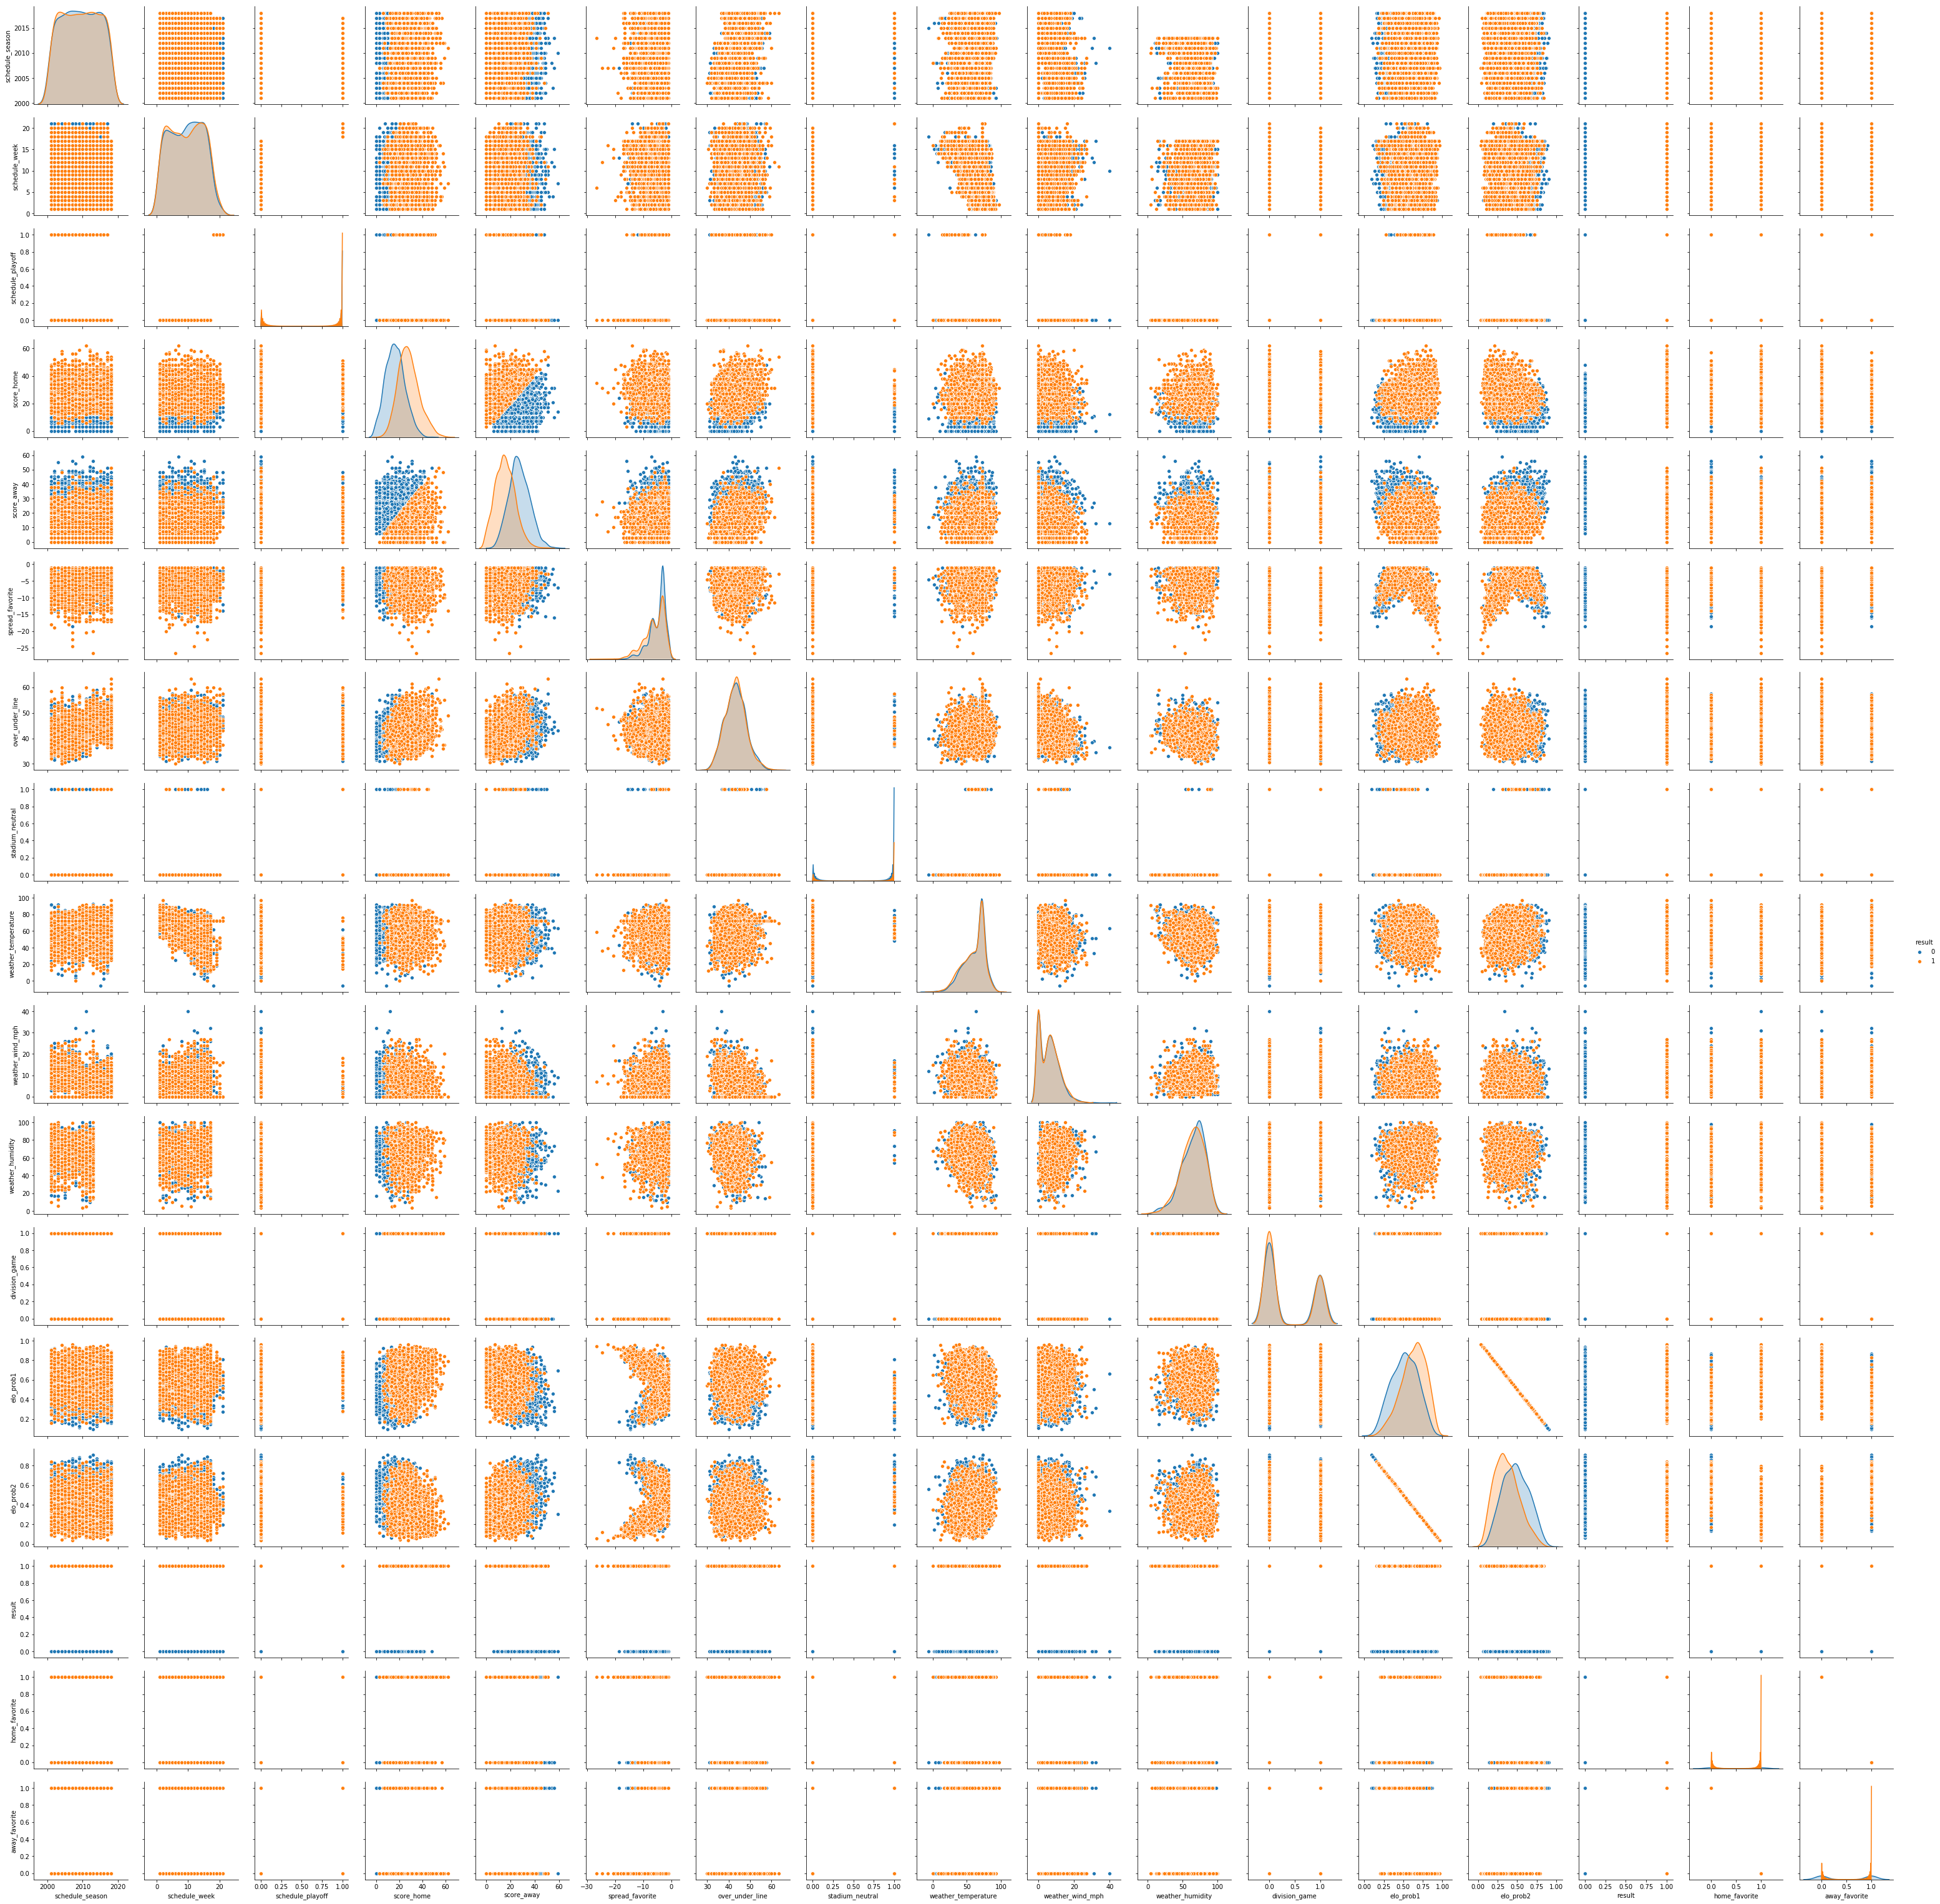

In [77]:
sns.pairplot(df, hue='result', height=2.5);

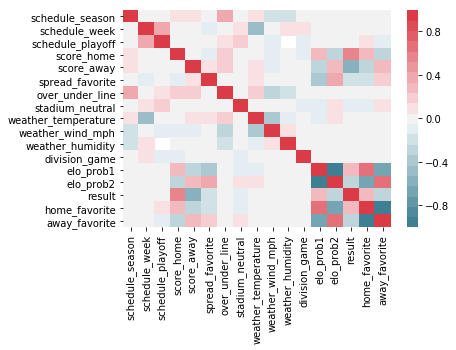

In [85]:
ax2 = sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap=sns.diverging_palette(h_neg=220,h_pos=10,n=21))

# Feature and Model Testing 
## Predict probability the the Home team will win p(y=1; x)

In [40]:
df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'team_home_division', 'team_away_division',
       'division_game', 'date', 'team1', 'team2', 'elo_prob1', 'elo_prob2',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'result', 'home_favorite', 'away_favorite'], dtype=object)

In [38]:
# Change boolean column to 0/1
df.division_game = df.division_game.astype(int)
df.home_favorite = df.home_favorite.astype(int)
df.away_favorite = df.away_favorite.astype(int)

In [41]:
# initial features possible for model
# X = df[['schedule_season', 'schedule_week', 'over_under_line', 'spread_favorite', 'weather_temperature', 'weather_wind_mph',
#         'home_favorite', 'hm_avg_pts_diff','aw_avg_pts_diff', 'elo1', 'elo2', 'elo_prob1']]
X = df[['schedule_week', 'spread_favorite', 'division_game', 'elo_prob1', 'elo_prob2', 'home_favorite', 'away_favorite', 'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct']]

y = df['result']

In [42]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
schedule_week,4783.0,9.486933,5.254918,1.000000,5.000000,10.000000,14.000000,21.000000
spread_favorite,4783.0,-5.374242,3.387991,-26.500000,-7.000000,-4.500000,-3.000000,0.000000
elo_prob1,4783.0,0.582349,0.168648,0.092782,0.465489,0.591249,0.709157,0.964578
elo_prob2,4783.0,0.417651,0.168648,0.035422,0.290843,0.408751,0.534511,0.907218
home_favorite,4783.0,0.664227,0.472309,0.000000,0.000000,1.000000,1.000000,1.000000
away_favorite,4783.0,0.328037,0.469547,0.000000,0.000000,0.000000,1.000000,1.000000
team_away_current_win_pct,4783.0,0.497123,0.258996,0.000000,0.333333,0.500000,0.666667,1.000000
team_home_current_win_pct,4783.0,0.518837,0.263209,0.000000,0.333333,0.500000,0.687500,1.000000
team_home_lastseason_win_pct,4783.0,0.503174,0.194765,0.000000,0.375000,0.500000,0.625000,1.000000
team_away_lastseason_win_pct,4783.0,0.501777,0.193955,0.000000,0.375000,0.500000,0.625000,1.000000


In [43]:
# required machine learning packages
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb

In [54]:
# training and testing data (2017 and 2018)
train = df.copy()
test = df.copy()
train = train.loc[train['schedule_season'] < 2016]
test = test.loc[test['schedule_season'] > 2015]
X_train = train[['schedule_week', 'spread_favorite', 'division_game', 'elo_prob1', 'elo_prob2', 'home_favorite', 'away_favorite', 'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct']]
y_train = train['result']
X_test = test[['schedule_week', 'spread_favorite', 'division_game', 'elo_prob1', 'elo_prob2', 'home_favorite', 'away_favorite', 'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct']]
y_test = test['result']

In [55]:
# calibrate probabilities and fit model to training data
boost = xgb.XGBClassifier()
dtc = DecisionTreeClassifier(max_depth=5, criterion='entropy')
lrg = LogisticRegression(solver='liblinear')
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')

# model = CCV(vote, method='isotonic', cv=3)
# model.fit(X_train, y_train)

In [56]:
model = lrg.fit(X_train, y_train)

In [57]:
# predict probabilities
predicted = model.predict_proba(X_test)[:,1]

In [58]:
model.score(X_test, y_test)

0.86582278481012653

In [59]:
predictions = model.predict(X_test)

In [60]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[266  63]
 [ 43 418]]


In [61]:
model.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)>

In [63]:
# [['schedule_week', 'spread_favorite', 'division_game', 'elo_prob1', 'elo_prob2', 
#'home_favorite', 'away_favorite', 'team_away_current_win_pct', 'team_home_current_win_pct', 'team_home_lastseason_win_pct',
#  'team_away_lastseason_win_pct']]
model.coef_

array([[-0.02635123, -0.01196408, -0.17881203, -4.71063395,  5.72471829,
         0.14982881, -0.19599269, -8.81456681,  8.58566109,  3.07955035,
        -2.93152319]])

## Bets simulation 
Bet if more than 0.60 prob

In [64]:
test.loc[:,'hm_prob'] = predicted
test = test[['schedule_season', 'schedule_week', 'team_home', 'team_away', 'elo_prob1', 'hm_prob', 'result']]

In [65]:
# calulate bets won (only make a bet when probability is greater than / equal to 60% or less than / equal to 40%)
test['my_bet_won'] = (((test.hm_prob >= 0.60) & (test.result == 1)) | ((test.hm_prob <= 0.40) & (test.result == 0))).astype(int)
test['elo_bet_won'] = (((test.elo_prob1 >= 0.60) & (test.result == 1)) | ((test.elo_prob1 <= 0.40) & (test.result == 0))).astype(int)

# calulate bets lost (only make a bet when probability is greater than / equal to 60% or less than / equal to 40%)
test['my_bet_lost'] = (((test.hm_prob >= 0.60) & (test.result == 0)) | ((test.hm_prob <= 0.40) & (test.result == 1))).astype(int)
test['elo_bet_lost'] = (((test.elo_prob1 >= 0.60) & (test.result == 0)) | ((test.elo_prob1 <= 0.40) & (test.result == 1))).astype(int)

In [66]:
# printing some quick overall results for my model
print("My Model Win Percentage: " + "{:.4f}".format(test.my_bet_won.sum() / (test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.my_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Possible Games: " + str(len(test)))

My Model Win Percentage: 0.9158
Total Number of Bets Won: 620
Total Number of Bets Made: 677
Possible Games: 790


In [67]:
# printing some quick overall results for fivethirtyeight's ELO model
print("ELO Model Win Percentage: " + "{:.4f}".format(test.elo_bet_won.sum()/(test.elo_bet_lost.sum() + test.elo_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.elo_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.elo_bet_lost.sum() + test.elo_bet_won.sum())))
print("Possible Games: " + str(len(test)))

ELO Model Win Percentage: 0.6896
Total Number of Bets Won: 351
Total Number of Bets Made: 509
Possible Games: 790


In [68]:
# creating week by week results
results_df = test.groupby(['schedule_season', 'schedule_week']).agg({'team_home' : 'count', 'my_bet_won' : 'sum', 
'elo_bet_won' : 'sum', 'my_bet_lost' : 'sum', 'elo_bet_lost' : 'sum'}).reset_index().rename(columns=
                                                                                            {'team_home' : 'total_games'})

# counting total bets for my model and the ELO model (prob >= 60% or prob <= 40%)
results_df['total_bets'] = results_df.my_bet_won + results_df.my_bet_lost
results_df['elo_total_bets'] = results_df.elo_bet_won + results_df.elo_bet_lost

# creating accuracy columns based on bets made not on total games
results_df['bet_accuracy'] = round((results_df.my_bet_won / results_df.total_bets) * 100, 2)
results_df['elo_bet_accuracy'] = round((results_df.elo_bet_won / results_df.elo_total_bets) * 100, 2)
results_df = results_df[['schedule_season', 'schedule_week', 'bet_accuracy', 'elo_bet_accuracy',
                         'total_bets', 'elo_total_bets', 'total_games']]

In [69]:
results_df

,schedule_season,schedule_week,bet_accuracy,elo_bet_accuracy,total_bets,elo_total_bets,total_games
0,2016,1,100.00,66.67,16,9,16
1,2016,2,100.00,63.64,14,11,16
2,2016,3,93.75,77.78,16,9,16
3,2016,4,92.86,50.00,14,10,15
4,2016,5,85.71,60.00,14,10,14
5,2016,6,85.71,60.00,14,10,15
6,2016,7,75.00,66.67,12,6,15
7,2016,8,84.62,60.00,13,5,13
8,2016,9,81.82,57.14,11,7,13
9,2016,10,100.00,42.86,12,7,14
